## model: dzien roboczy- swieto

### getting data

In [1]:
import pandas as pd
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

end = '2019-03-31'
# #2 months:
# start = '2019-02-01'

#6 months:
start = '2018-10-01'

# 12 months:
# start = '2018-04-01'

# #24 months:
# start = '2017-04-01'

# # #60 months:
# start = '2014-04-01'



weekdays =['Pon', 'Wt', 'Sr', 'Czw', 'Pt', 'Sb', 'Nd']

def dzienTyg(dzienNum):
    if dzienNum == 0:
        return 'Pon'
    elif dzienNum == 1:
        return 'Wt'
    elif dzienNum == 2:
        return 'Sr'
    elif dzienNum == 3:
        return 'Czw'
    elif dzienNum == 4:
        return 'Pt'
    elif dzienNum == 5:
        return 'Sb'
    elif dzienNum == 6:
        return 'Nd'
    else:
        return 'Blad'
def date_fromisofromat(dt):
    y = int(dt[0: 4])
    m = int(dt[5: 7])
    d = int(dt[8:10])
    return date(y,m,d)

def combineData(start, end):
    startDt = date_fromisofromat(start)
    endDt   = date_fromisofromat(end)
    d = datetime.timedelta(days=1)
    m = relativedelta(months=+1)

    in_table = pd.read_csv(filepath_or_buffer= '../Data/20100301-20100331.csv', 
                       sep=';', 
                       engine='python')
    in_table= in_table.iloc[0:0] #drop all rows, leave columns

    while(startDt <= endDt):
        fileName = str(startDt).replace('-','') + '-' + str(startDt + m - d).replace('-','') + '.csv'
        in_table1 = pd.read_csv(filepath_or_buffer= '../Data/' +fileName, 
                           sep=';', 
                           engine='python')
        in_table = in_table.append(in_table1,ignore_index=True)
        startDt = startDt + relativedelta(months=+1)

    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].apply(lambda x: x.replace(',','.'))
    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].astype(float)
    in_table['Rok']     = in_table['Data'].apply(lambda x: x[0: 4]).astype(int)
    in_table['Miesiac'] = in_table['Data'].apply(lambda x: x[5: 7]).astype(int)
    in_table['Dzien']   = in_table['Data'].apply(lambda x: x[8:10]).astype(int)
    # in_table['Godz_mies']=(in_table['Dzien']-1)*24 +in_table['Godzina']
    return in_table
#     plt.show()
# Data, Godzina, Krajowe zapotrzebowanie na moc, Sumaryczna generacja JWCD, 
# Generacja PI, Generacja IRZ, Sumaryczna generacja nJWCD, 
# Krajowe saldo wymiany międzysystemowej równoległej, 
# Krajowe saldo wymiany międzysystemowej nierównoległej, 

dataAll = combineData(start, end)
dataAll = dataAll.loc[dataAll['Godzina'] != '2A']

dataAll['Godzina'] = dataAll['Godzina'].apply(
    lambda x: (int(str(x)))
)
dataAll['weekDayNum'] = dataAll['Data'].apply(
    lambda x: (date_fromisofromat(x).weekday())
)
dataAll['weekDay'] = dataAll['Data'].apply(
    lambda x: dzienTyg(date_fromisofromat(x).weekday())
)
dataAll['DataGodz'] = pd.to_datetime(dataAll['Data']) 

dataAll['DataGodz'] = dataAll['DataGodz'] + dataAll['Godzina'].apply(
    lambda x: relativedelta(hours=x)
)
    
modelData = dataAll[['Krajowe zapotrzebowanie na moc']]

#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz']] 
modelData2.set_index('DataGodz')
modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

modelData2

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


,Krajowe zapotrzebowanie na moc,DataGodz
DataGodz,,
2018-10-01 01:00:00,14878.950,2018-10-01 01:00:00
2018-10-01 02:00:00,14456.888,2018-10-01 02:00:00
2018-10-01 03:00:00,14335.488,2018-10-01 03:00:00
2018-10-01 04:00:00,14358.488,2018-10-01 04:00:00
2018-10-01 05:00:00,14781.700,2018-10-01 05:00:00
...,...,...
2019-03-31 20:00:00,18097.938,2019-03-31 20:00:00
2019-03-31 21:00:00,18774.000,2019-03-31 21:00:00
2019-03-31 22:00:00,17979.813,2019-03-31 22:00:00


In [2]:
dataAll
#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz','weekDay']] 
# modelData2.set_index('DataGodz')
# modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

In [3]:
modelData2_workdays=modelData2[modelData2['weekDay'].isin(('Pon', 'Wt', 'Sr', 'Czw', 'Pt'))]

In [4]:
modelData2_workdays.set_index('DataGodz')
modelData2_workdays.index = pd.DatetimeIndex(modelData2_workdays['DataGodz'])#.to_period('H')

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
def create_model(dane, sezon, maxiter = 20):
    start = datetime.now()

    #auto ARIMA
    m = auto_arima(dane,                
                   seasonal = True, 
                   m=sezon, 
#                    max_p = 1,
#                    max_d = 1,
#                    max_q = 1, 
                   max_P = 0,
#                    max_D = 0,
                   max_Q = 0,                    
                   start_p = 0,
                   start_d = 0,
                   start_q = 0,
                   start_P = 0,
                   start_Q = 0,
                   start_D = 0,
                   maxiter = maxiter,
                   trace = True)#.summary()
    print('autoARIMA time: ' + str(datetime.now() - start))
    order = m.get_params()['order']
    seasonal_order = m.get_params()['seasonal_order']
    print(order)
    print(seasonal_order)
    #SARIMAX
    fit_start =  datetime.now()
    model = SARIMAX(dane, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    model_fit = model.fit() 
    
    print('fit time = ' + str(datetime.now() - fit_start))
    return model_fit

In [16]:
short_dataAll = dataAll[dataAll['DataGodz'] > pd.to_datetime('2019-02-25') ]

In [17]:
starttime = datetime.now()
my_model = create_model(short_dataAll['Krajowe zapotrzebowanie na moc'],168)
print('czas calosci = ' + str(datetime.now() - starttime))    

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[168]             : AIC=8620.280, Time=11.98 sec
 ARIMA(1,1,0)(0,1,0)[168]             : AIC=8620.120, Time=134.72 sec
 ARIMA(0,1,2)(0,1,0)[168]             : AIC=8618.954, Time=447.57 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,1,0)[168]             : AIC=8604.336, Time=399.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MemoryError: Unable to allocate 192. MiB for an array with shape (173, 173, 839) and data type float64

In [ ]:
modelData2_weekends=modelData2[modelData2['weekDay'].isin(('Sb', 'Nd'))]

In [ ]:
my_model2 = create_model(modelData2_weekends['Krajowe zapotrzebowanie na moc'],24)

In [ ]:
print('czas calosci = ' + str(datetime.now() - starttime))    

In [ ]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

### Prognozowanie

In [16]:
# forecast_steps = int(2260/7)
forecasted_data=[None]*2
forecasted_data[0] = my_model.forecast(int(2260/7*5))
# forecasted_data[1] = my_model2.forecast(int(2260/7*2))

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:>

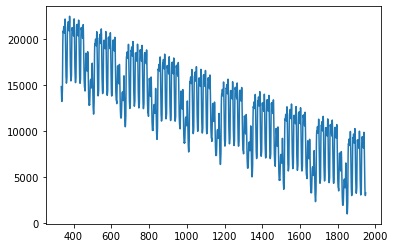

In [18]:
forecasted_data[0].plot()

In [ ]:
combined_forecasted_data = [None] * 2238
for i in range(2238):
    if(i%168 in range(5*24)):
        combined_forecasted_data[i] = forecasted_data[0].iloc[i-48*(int(i/168))]
    else:
        combined_forecasted_data[i] = forecasted_data[1].iloc[i-5*24*(1+int(i/168))]
    print(combined_forecasted_data[i])

In [ ]:
combined_forecasted_data = pd.Series(combined_forecasted_data)

In [ ]:
combined_forecasted_data

### Obliczanie bledu

In [ ]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
test_start = '2019-04-01'
test_end = '2020-02-29'

In [ ]:
import datetime
test_data = combineData(test_start, test_end)['Krajowe zapotrzebowanie na moc']

In [ ]:
sample = 2160
mean_absolute_percentage_error(test_data.iloc[:sample], combined_forecasted_data.iloc[:sample])
# test_data

In [ ]:
print('czas trwania calosci: ' +str(datetime.datetime.now()-starttime))

In [ ]:
plt.figure(figsize=[20,5])
test_data.iloc[:sample].plot()
combined_forecasted_data.iloc[:sample].plot()

In [ ]:
sample = 720
mean_absolute_percentage_error(test_data.iloc[:sample], combined_forecasted_data.iloc[:sample])